In [1]:
# =======================
# INSTALL DEPENDENCIES
# =======================
!pip install tensorflow numpy matplotlib opencv-python scikit-learn albumentations

In [2]:
import os, random, csv
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from datetime import datetime
import albumentations as A
from google.colab import drive

In [3]:
# fix seeds
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# =======================
# LOAD DATA
# =======================
def load_data(image_dir, mask_dir, img_size=(256, 256)):
    images, masks = [], []
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    for img_file, mask_file in zip(image_files, mask_files):
        img = cv2.imread(os.path.join(image_dir, img_file))
        img = cv2.resize(img, img_size) / 255.0
        images.append(img)

        mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img_size)
        mask = np.expand_dims(mask, axis=-1)
        mask = mask / 255.0
        masks.append(mask)

    return np.array(images), np.array(masks)

# Update with your Google Drive paths
image_dir = '/content/drive/MyDrive/Project3/disaster/Image'
mask_dir = '/content/drive/MyDrive/Project3/disaster/Mask'

images, masks = load_data(image_dir, mask_dir)
print(f"Loaded {len(images)} images and {len(masks)} masks")

Loaded 290 images and 290 masks


In [6]:
# =======================
# SPLIT DATA
# =======================
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Train: 185, Val: 47, Test: 58


In [7]:
# =======================
# METRICS & LOSS
# =======================
def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(tf.round(y_pred), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection + smooth)

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def focal_loss(y_true, y_pred, gamma=2., alpha=0.25):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    loss = - (alpha * y_true * tf.math.pow(1 - y_pred, gamma) * tf.math.log(y_pred) +
              (1 - alpha) * (1 - y_true) * tf.math.pow(y_pred, gamma) * tf.math.log(1 - y_pred))
    return tf.reduce_mean(loss)

def total_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + focal_loss(y_true, y_pred)

In [8]:
# =======================
# U-NET MODEL
# =======================
def unet_model(input_size=(256,256,3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D(2)(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D(2)(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D(2)(c3)

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D(2)(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, 2, strides=2, padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c9)

    model = models.Model(inputs, outputs)
    return model


In [9]:
# =======================
# COMPILE MODEL
# =======================
model = unet_model()
model.compile(optimizer="adam", loss=total_loss, metrics=["accuracy", dice_coef, iou_coef])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# =======================
# TRAIN MODEL
# =======================
checkpoint = ModelCheckpoint("best_unet.h5", monitor="val_loss", save_best_only=True, mode="min")
earlystop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=8,
    callbacks=[checkpoint, earlystop]
)


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4832 - dice_coef: 0.4875 - iou_coef: 0.3920 - loss: 0.6198   

24/24 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - accuracy: 0.4878 - dice_coef: 0.4896 - iou_coef: 0.3954 - loss: 0.6179 - val_accuracy: 0.6669 - val_dice_coef: 0.6436 - val_iou_coef: 0.5289 - val_loss: 0.6676
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.6791 - dice_coef: 0.5879 - iou_coef: 0.5190 - loss: 0.6045

24/24 ━━━━━━━━━━━━━━━━━━━━ 35s 497ms/step - accuracy: 0.6793 - dice_coef: 0.5868 - iou_coef: 0.5197 - loss: 0.6036 - val_accuracy: 0.6605 - val_dice_coef: 0.5438 - val_iou_coef: 0.5231 - val_loss: 0.5976
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.7015 - dice_coef: 0.5523 - iou_coef: 0.5106 - loss: 0.5669

24/24 ━━━━━━━━━━━━━━━━━━━━ 27s 783ms/step - accuracy: 0.7023 - dice_coef: 0.5528 - iou_coef: 0.5110 - loss: 0.5666 - val_accuracy: 0.7655 - val_dice_coef: 0.5312 - val_iou_coef: 0.5382 - val_loss: 0.5297
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.7181 - dice_coef: 0.5487 - iou_coef: 0.5120 - loss: 0.5610

24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 788ms/step - accuracy: 0.7187 - dice_coef: 0.5500 - iou_coef: 0.5134 - loss: 0.5601 - val_accuracy: 0.7665 - val_dice_coef: 0.6530 - val_iou_coef: 0.5782 - val_loss: 0.4802
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 442ms/step - accuracy: 0.7461 - dice_coef: 0.6358 - iou_coef: 0.5394 - loss: 0.4931 - val_accuracy: 0.7449 - val_dice_coef: 0.6530 - val_iou_coef: 0.5736 - val_loss: 0.4985
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 441ms/step - accuracy: 0.7194 - dice_coef: 0.6251 - iou_coef: 0.5300 - loss: 0.5671 - val_accuracy: 0.6744 - val_dice_coef: 0.6437 - val_iou_coef: 0.5278 - val_loss: 0.6651
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 447ms/step - accuracy: 0.7384 - dice_coef: 0.6375 - iou_coef: 0.5543 - loss: 0.5077 - val_accuracy: 0.7542 - val_dice_coef: 0.6595 - val_iou_coef: 0.5755 - val_loss: 0.4900
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.7505 - dice_coef: 0.6487 - iou_coef: 0.5570 - loss: 0.4814

24/24 ━━━━━━━━━━━━━━━━━━━━ 28s 761ms/step - accuracy: 0.7513 - dice_coef: 0.6491 - iou_coef: 0.5583 - loss: 0.4802 - val_accuracy: 0.7634 - val_dice_coef: 0.6708 - val_iou_coef: 0.5803 - val_loss: 0.4780
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.7568 - dice_coef: 0.6541 - iou_coef: 0.5547 - loss: 0.4729

24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 721ms/step - accuracy: 0.7576 - dice_coef: 0.6544 - iou_coef: 0.5560 - loss: 0.4718 - val_accuracy: 0.7743 - val_dice_coef: 0.6707 - val_iou_coef: 0.5874 - val_loss: 0.4587
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 444ms/step - accuracy: 0.7630 - dice_coef: 0.6585 - iou_coef: 0.5615 - loss: 0.4574 - val_accuracy: 0.7724 - val_dice_coef: 0.6828 - val_iou_coef: 0.5869 - val_loss: 0.4700
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.7611 - dice_coef: 0.6598 - iou_coef: 0.5586 - loss: 0.4683

24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 515ms/step - accuracy: 0.7618 - dice_coef: 0.6600 - iou_coef: 0.5599 - loss: 0.4672 - val_accuracy: 0.7778 - val_dice_coef: 0.6787 - val_iou_coef: 0.5941 - val_loss: 0.4524
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.7664 - dice_coef: 0.6654 - iou_coef: 0.5650 - loss: 0.4514

24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 690ms/step - accuracy: 0.7670 - dice_coef: 0.6658 - iou_coef: 0.5661 - loss: 0.4506 - val_accuracy: 0.7854 - val_dice_coef: 0.6825 - val_iou_coef: 0.6039 - val_loss: 0.4469
Epoch 13/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.7669 - dice_coef: 0.6665 - iou_coef: 0.5693 - loss: 0.4509

24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 560ms/step - accuracy: 0.7676 - dice_coef: 0.6670 - iou_coef: 0.5707 - loss: 0.4498 - val_accuracy: 0.7956 - val_dice_coef: 0.6846 - val_iou_coef: 0.6107 - val_loss: 0.4296
Epoch 14/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 461ms/step - accuracy: 0.7750 - dice_coef: 0.6778 - iou_coef: 0.5802 - loss: 0.4334 - val_accuracy: 0.7899 - val_dice_coef: 0.6878 - val_iou_coef: 0.6101 - val_loss: 0.4382
Epoch 15/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.7752 - dice_coef: 0.6758 - iou_coef: 0.5840 - loss: 0.4391

24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 590ms/step - accuracy: 0.7759 - dice_coef: 0.6763 - iou_coef: 0.5852 - loss: 0.4381 - val_accuracy: 0.8049 - val_dice_coef: 0.6905 - val_iou_coef: 0.6191 - val_loss: 0.4158
Epoch 16/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 443ms/step - accuracy: 0.7655 - dice_coef: 0.6617 - iou_coef: 0.5638 - loss: 0.4642 - val_accuracy: 0.7506 - val_dice_coef: 0.6717 - val_iou_coef: 0.5849 - val_loss: 0.4884
Epoch 17/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.7613 - dice_coef: 0.6669 - iou_coef: 0.5730 - loss: 0.4531

24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 487ms/step - accuracy: 0.7622 - dice_coef: 0.6674 - iou_coef: 0.5743 - loss: 0.4520 - val_accuracy: 0.8028 - val_dice_coef: 0.6817 - val_iou_coef: 0.6187 - val_loss: 0.4152
Epoch 18/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 436ms/step - accuracy: 0.7819 - dice_coef: 0.6830 - iou_coef: 0.5986 - loss: 0.4195 - val_accuracy: 0.7977 - val_dice_coef: 0.7030 - val_iou_coef: 0.6235 - val_loss: 0.4221
Epoch 19/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 455ms/step - accuracy: 0.7831 - dice_coef: 0.6918 - iou_coef: 0.5987 - loss: 0.4226 - val_accuracy: 0.7977 - val_dice_coef: 0.6980 - val_iou_coef: 0.6223 - val_loss: 0.4243
Epoch 20/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.7876 - dice_coef: 0.6925 - iou_coef: 0.6042 - loss: 0.4170

24/24 ━━━━━━━━━━━━━━━━━━━━ 26s 687ms/step - accuracy: 0.7882 - dice_coef: 0.6930 - iou_coef: 0.6053 - loss: 0.4160 - val_accuracy: 0.8090 - val_dice_coef: 0.7016 - val_iou_coef: 0.6273 - val_loss: 0.4052
Epoch 21/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 436ms/step - accuracy: 0.7949 - dice_coef: 0.7014 - iou_coef: 0.6127 - loss: 0.4046 - val_accuracy: 0.7849 - val_dice_coef: 0.7012 - val_iou_coef: 0.6157 - val_loss: 0.4360
Epoch 22/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 437ms/step - accuracy: 0.7848 - dice_coef: 0.6894 - iou_coef: 0.6084 - loss: 0.4257 - val_accuracy: 0.7908 - val_dice_coef: 0.6939 - val_iou_coef: 0.6184 - val_loss: 0.4254
Epoch 23/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 437ms/step - accuracy: 0.7844 - dice_coef: 0.6882 - iou_coef: 0.6086 - loss: 0.4223 - val_accuracy: 0.7918 - val_dice_coef: 0.7014 - val_iou_coef: 0.6185 - val_loss: 0.4264
Epoch 24/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 435ms/step - accuracy: 0.7855 - dice_coef: 0.6900 - iou_coef: 0.6118 - loss: 0.4211 - val_accuracy: 0.781

24/24 ━━━━━━━━━━━━━━━━━━━━ 26s 692ms/step - accuracy: 0.8017 - dice_coef: 0.7084 - iou_coef: 0.6310 - loss: 0.3961 - val_accuracy: 0.8150 - val_dice_coef: 0.7124 - val_iou_coef: 0.6283 - val_loss: 0.3912
Epoch 29/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 456ms/step - accuracy: 0.8103 - dice_coef: 0.7208 - iou_coef: 0.6405 - loss: 0.3842 - val_accuracy: 0.8122 - val_dice_coef: 0.7147 - val_iou_coef: 0.6312 - val_loss: 0.3942
Epoch 30/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 442ms/step - accuracy: 0.8101 - dice_coef: 0.7196 - iou_coef: 0.6427 - loss: 0.3855 - val_accuracy: 0.7987 - val_dice_coef: 0.7153 - val_iou_coef: 0.6245 - val_loss: 0.4164
Epoch 31/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 433ms/step - accuracy: 0.8013 - dice_coef: 0.7139 - iou_coef: 0.6300 - loss: 0.3940 - val_accuracy: 0.8182 - val_dice_coef: 0.6900 - val_iou_coef: 0.6078 - val_loss: 0.3949
Epoch 32/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.8170 - dice_coef: 0.7195 - iou_coef: 0.6439 - loss: 0.3694

24/24 ━━━━━━━━━━━━━━━━━━━━ 28s 758ms/step - accuracy: 0.8173 - dice_coef: 0.7203 - iou_coef: 0.6449 - loss: 0.3688 - val_accuracy: 0.8166 - val_dice_coef: 0.7170 - val_iou_coef: 0.6363 - val_loss: 0.3861
Epoch 33/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 438ms/step - accuracy: 0.8133 - dice_coef: 0.7236 - iou_coef: 0.6478 - loss: 0.3709 - val_accuracy: 0.8096 - val_dice_coef: 0.7172 - val_iou_coef: 0.6312 - val_loss: 0.4037
Epoch 34/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.8080 - dice_coef: 0.7228 - iou_coef: 0.6413 - loss: 0.3845

24/24 ━━━━━━━━━━━━━━━━━━━━ 26s 669ms/step - accuracy: 0.8086 - dice_coef: 0.7233 - iou_coef: 0.6423 - loss: 0.3835 - val_accuracy: 0.8235 - val_dice_coef: 0.7313 - val_iou_coef: 0.6462 - val_loss: 0.3739
Epoch 35/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.8187 - dice_coef: 0.7340 - iou_coef: 0.6517 - loss: 0.3667

24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 700ms/step - accuracy: 0.8190 - dice_coef: 0.7344 - iou_coef: 0.6523 - loss: 0.3662 - val_accuracy: 0.8258 - val_dice_coef: 0.7307 - val_iou_coef: 0.6501 - val_loss: 0.3719
Epoch 36/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 439ms/step - accuracy: 0.8208 - dice_coef: 0.7357 - iou_coef: 0.6567 - loss: 0.3613 - val_accuracy: 0.8209 - val_dice_coef: 0.7217 - val_iou_coef: 0.6420 - val_loss: 0.3863
Epoch 37/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 456ms/step - accuracy: 0.8143 - dice_coef: 0.7332 - iou_coef: 0.6478 - loss: 0.3737 - val_accuracy: 0.8157 - val_dice_coef: 0.7201 - val_iou_coef: 0.6476 - val_loss: 0.3914
Epoch 38/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 437ms/step - accuracy: 0.8174 - dice_coef: 0.7323 - iou_coef: 0.6527 - loss: 0.3669 - val_accuracy: 0.8254 - val_dice_coef: 0.7242 - val_iou_coef: 0.6480 - val_loss: 0.3733
Epoch 39/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 438ms/step - accuracy: 0.8218 - dice_coef: 0.7329 - iou_coef: 0.6560 - loss: 0.3623 - val_accuracy: 0.828

24/24 ━━━━━━━━━━━━━━━━━━━━ 27s 745ms/step - accuracy: 0.8231 - dice_coef: 0.7399 - iou_coef: 0.6606 - loss: 0.3603 - val_accuracy: 0.8326 - val_dice_coef: 0.7265 - val_iou_coef: 0.6470 - val_loss: 0.3648
Epoch 42/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.8265 - dice_coef: 0.7416 - iou_coef: 0.6621 - loss: 0.3507

24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 579ms/step - accuracy: 0.8269 - dice_coef: 0.7423 - iou_coef: 0.6632 - loss: 0.3501 - val_accuracy: 0.8326 - val_dice_coef: 0.7221 - val_iou_coef: 0.6512 - val_loss: 0.3635
Epoch 43/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 458ms/step - accuracy: 0.8362 - dice_coef: 0.7473 - iou_coef: 0.6825 - loss: 0.3389 - val_accuracy: 0.8334 - val_dice_coef: 0.7143 - val_iou_coef: 0.6398 - val_loss: 0.3661
Epoch 44/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.8347 - dice_coef: 0.7482 - iou_coef: 0.6755 - loss: 0.3367 - val_accuracy: 0.8365 - val_dice_coef: 0.7331 - val_iou_coef: 0.6544 - val_loss: 0.3656
Epoch 45/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.8350 - dice_coef: 0.7461 - iou_coef: 0.6798 - loss: 0.3400

24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 636ms/step - accuracy: 0.8354 - dice_coef: 0.7470 - iou_coef: 0.6807 - loss: 0.3392 - val_accuracy: 0.8351 - val_dice_coef: 0.7476 - val_iou_coef: 0.6712 - val_loss: 0.3587
Epoch 46/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 434ms/step - accuracy: 0.8371 - dice_coef: 0.7534 - iou_coef: 0.6847 - loss: 0.3379 - val_accuracy: 0.8377 - val_dice_coef: 0.7415 - val_iou_coef: 0.6537 - val_loss: 0.3642
Epoch 47/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.8383 - dice_coef: 0.7582 - iou_coef: 0.6871 - loss: 0.3333

24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 806ms/step - accuracy: 0.8385 - dice_coef: 0.7587 - iou_coef: 0.6879 - loss: 0.3327 - val_accuracy: 0.8350 - val_dice_coef: 0.7557 - val_iou_coef: 0.6715 - val_loss: 0.3582
Epoch 48/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.8325 - dice_coef: 0.7545 - iou_coef: 0.6776 - loss: 0.3461

24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 658ms/step - accuracy: 0.8329 - dice_coef: 0.7550 - iou_coef: 0.6785 - loss: 0.3453 - val_accuracy: 0.8405 - val_dice_coef: 0.7384 - val_iou_coef: 0.6547 - val_loss: 0.3563
Epoch 49/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.8421 - dice_coef: 0.7590 - iou_coef: 0.6898 - loss: 0.3263

24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 497ms/step - accuracy: 0.8425 - dice_coef: 0.7599 - iou_coef: 0.6909 - loss: 0.3254 - val_accuracy: 0.8458 - val_dice_coef: 0.7600 - val_iou_coef: 0.6763 - val_loss: 0.3430
Epoch 50/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 443ms/step - accuracy: 0.8457 - dice_coef: 0.7682 - iou_coef: 0.6994 - loss: 0.3185 - val_accuracy: 0.8416 - val_dice_coef: 0.7490 - val_iou_coef: 0.6603 - val_loss: 0.3574


In [11]:
# =======================
# EVALUATE ON TEST SET
# =======================
results = model.evaluate(X_test, y_test, verbose=1)
print(f"\nTest Results:")
print(f"Loss: {results[0]:.4f}")
print(f"Accuracy: {results[1]:.4f}")
print(f"Dice: {results[2]:.4f}")
print(f"IoU: {results[3]:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 83s 39s/step - accuracy: 0.8530 - dice_coef: 0.7800 - iou_coef: 0.7058 - loss: 0.3006

Test Results:
Loss: 0.2963
Accuracy: 0.8555
Dice: 0.7833
IoU: 0.7101


1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


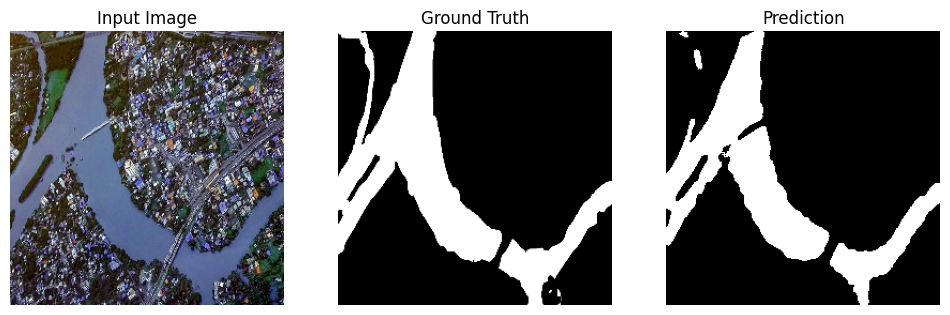

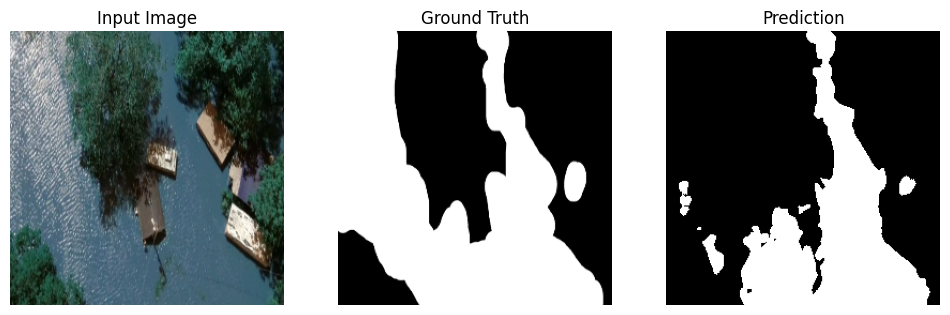

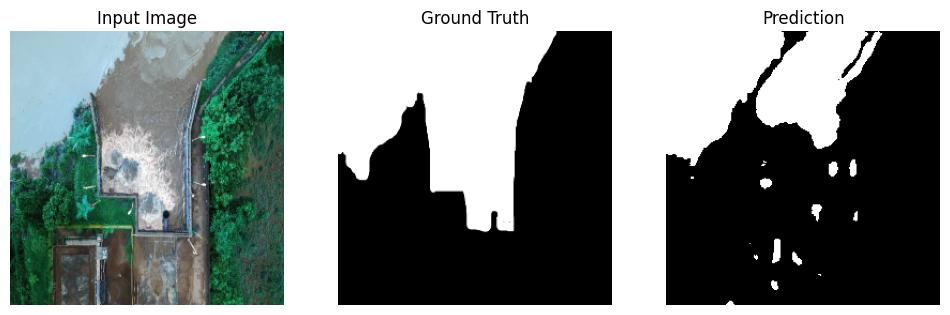

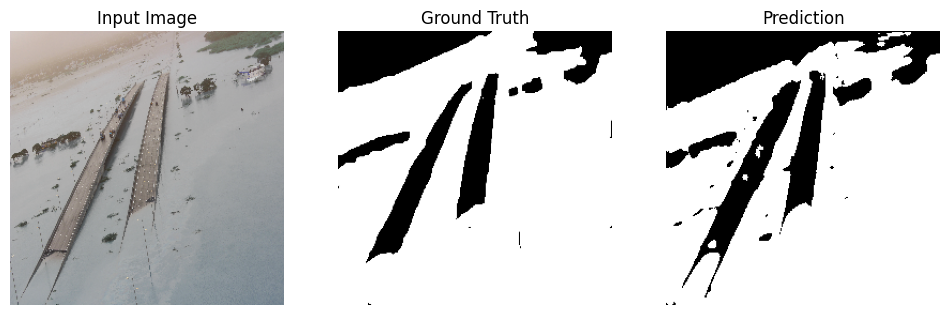

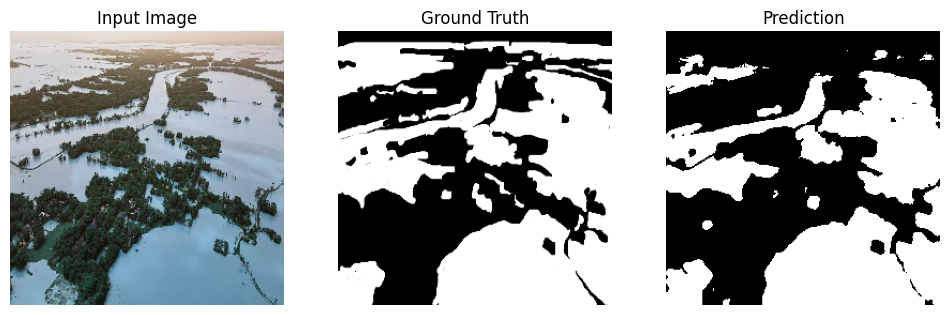

In [12]:
# =======================
# VISUALIZE TEST PREDICTIONS
# =======================
def visualize_predictions(model, X, y, num_samples=3):
    indices = np.random.choice(len(X), num_samples, replace=False)
    preds = model.predict(X[indices])

    for i, idx in enumerate(indices):
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.imshow(X[idx])
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.imshow(y[idx].squeeze(), cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.imshow((preds[i].squeeze() > 0.5).astype(np.uint8), cmap="gray")
        plt.title("Prediction")
        plt.axis("off")

        plt.show()

visualize_predictions(model, X_test, y_test, num_samples=5)

In [13]:

# =========================
# 1) Load dataset
# =========================
def load_data(image_dir, mask_dir, img_size=(256,256)):
    images, masks = [], []
    image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))])
    mask_files  = sorted([f for f in os.listdir(mask_dir)  if f.lower().endswith(('.png','.jpg','.jpeg'))])
    assert len(image_files) == len(mask_files), "Number of images and masks must match"
    for img_f, m_f in zip(image_files, mask_files):
        img = cv2.imread(os.path.join(image_dir, img_f))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, img_size) / 255.0
        images.append(img.astype(np.float32))

        mask = cv2.imread(os.path.join(mask_dir, m_f), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img_size)
        mask = (mask > 127).astype(np.float32)  # binarize if needed
        mask = np.expand_dims(mask, -1)
        masks.append(mask.astype(np.float32))

    return np.array(images), np.array(masks)

# SET YOUR PATHS (update if different)
image_dir = '/content/drive/MyDrive/Project3/disaster/Image'
mask_dir  = '/content/drive/MyDrive/Project3/disaster/Mask'

images, masks = load_data(image_dir, mask_dir, img_size=(256,256))
print("Loaded:", images.shape, masks.shape)

Loaded: (290, 256, 256, 3) (290, 256, 256, 1)


Image shape: (290, 256, 256, 3)
Mask shape : (290, 256, 256, 1)
Mask coverage (min, mean, max): 0.04258728 0.40698585 0.8790283


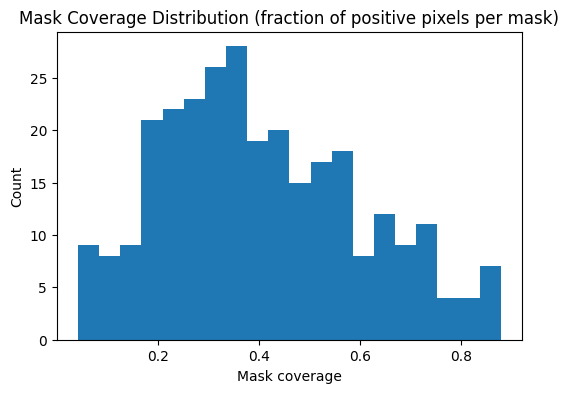

In [14]:
# =========================
# 2) EDA (quick)
# =========================
# Display shapes and mask coverage histogram
covers = masks.reshape(len(masks), -1).mean(axis=1)  # fraction of mask pixels per image
print("Image shape:", images.shape)
print("Mask shape :", masks.shape)
print("Mask coverage (min, mean, max):", covers.min(), covers.mean(), covers.max())

plt.figure(figsize=(6,4))
plt.hist(covers, bins=20)
plt.title("Mask Coverage Distribution (fraction of positive pixels per mask)")
plt.xlabel("Mask coverage")
plt.ylabel("Count")
plt.show()


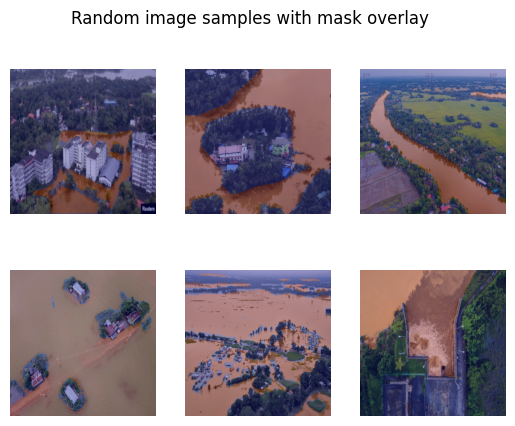

In [15]:
# Show random sample images with masks
def show_samples(X, Y, n=6):
    idxs = np.random.choice(len(X), size=min(n,len(X)), replace=False)
    rows = int(np.ceil(n/3))
    for i, idx in enumerate(idxs):
        plt.subplot(rows, 3, i+1)
        plt.imshow(X[idx])
        plt.imshow(Y[idx].squeeze(), cmap='jet', alpha=0.35)
        plt.axis('off')
    plt.suptitle("Random image samples with mask overlay")
    plt.show()

show_samples(images, masks, n=6)

In [16]:
# =========================
# 3) Train/Val/Test split
# =========================
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=SEED)
X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)
print("Train:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))


Train: 185 Val: 47 Test: 58


In [17]:
# =========================
# 4) Albumentations augmentation (applied to image+mask pairs)
# =========================
train_augs = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.RandomRotate90(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.4),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.4),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
], additional_targets={'mask':'mask'})

def augment_batch(X, Y, batch_size, aug):
    n = len(X)
    while True:
        idxs = np.random.choice(n, batch_size, replace=False)
        Xb = []
        Yb = []
        for i in idxs:
            sample = aug(image=(X[i]*255).astype('uint8'), mask=(Y[i]*255).astype('uint8'))
            img = sample['image'].astype(np.float32) / 255.0
            msk = (sample['mask'] > 127).astype(np.float32)
            msk = np.expand_dims(msk, -1)
            Xb.append(img)
            Yb.append(msk)
        yield np.array(Xb), np.array(Yb)


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-2416330998.py:10: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),


In [18]:
# =========================
# 5) Metrics & Losses
# =========================
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    # don't round here so metric is differentiable for logging
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1. - tf.keras.backend.epsilon())
    loss_pos = - alpha * y_true * tf.pow(1. - y_pred, gamma) * tf.math.log(y_pred)
    loss_neg = - (1 - alpha) * (1. - y_true) * tf.pow(y_pred, gamma) * tf.math.log(1. - y_pred)
    return tf.reduce_mean(loss_pos + loss_neg)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def total_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + focal_loss(y_true, y_pred)


In [19]:
# =========================
# 6) Models: Vanilla U-Net and ResNet50-encoder U-Net
# =========================
def unet_scratch(input_shape=(256,256,3), base_filters=64):
    inputs = layers.Input(input_shape)
    # encoder
    c1 = layers.Conv2D(base_filters,3,padding='same',activation='relu')(inputs)
    c1 = layers.Conv2D(base_filters,3,padding='same',activation='relu')(c1)
    p1 = layers.MaxPooling2D(2)(c1)

    c2 = layers.Conv2D(base_filters*2,3,padding='same',activation='relu')(p1)
    c2 = layers.Conv2D(base_filters*2,3,padding='same',activation='relu')(c2)
    p2 = layers.MaxPooling2D(2)(c2)

    c3 = layers.Conv2D(base_filters*4,3,padding='same',activation='relu')(p2)
    c3 = layers.Conv2D(base_filters*4,3,padding='same',activation='relu')(c3)
    p3 = layers.MaxPooling2D(2)(c3)

    c4 = layers.Conv2D(base_filters*8,3,padding='same',activation='relu')(p3)
    c4 = layers.Conv2D(base_filters*8,3,padding='same',activation='relu')(c4)
    p4 = layers.MaxPooling2D(2)(c4)

    c5 = layers.Conv2D(base_filters*16,3,padding='same',activation='relu')(p4)
    c5 = layers.Conv2D(base_filters*16,3,padding='same',activation='relu')(c5)

    # decoder
    u6 = layers.Conv2DTranspose(base_filters*8,2,strides=2,padding='same')(c5)
    u6 = layers.Concatenate()([u6,c4])
    c6 = layers.Conv2D(base_filters*8,3,padding='same',activation='relu')(u6)
    c6 = layers.Conv2D(base_filters*8,3,padding='same',activation='relu')(c6)

    u7 = layers.Conv2DTranspose(base_filters*4,2,strides=2,padding='same')(c6)
    u7 = layers.Concatenate()([u7,c3])
    c7 = layers.Conv2D(base_filters*4,3,padding='same',activation='relu')(u7)
    c7 = layers.Conv2D(base_filters*4,3,padding='same',activation='relu')(c7)

    u8 = layers.Conv2DTranspose(base_filters*2,2,strides=2,padding='same')(c7)
    u8 = layers.Concatenate()([u8,c2])
    c8 = layers.Conv2D(base_filters*2,3,padding='same',activation='relu')(u8)
    c8 = layers.Conv2D(base_filters*2,3,padding='same',activation='relu')(c8)

    u9 = layers.Conv2DTranspose(base_filters,2,strides=2,padding='same')(c8)
    u9 = layers.Concatenate()([u9,c1])
    c9 = layers.Conv2D(base_filters,3,padding='same',activation='relu')(u9)
    c9 = layers.Conv2D(base_filters,3,padding='same',activation='relu')(c9)

    outputs = layers.Conv2D(1,1,activation='sigmoid')(c9)
    return models.Model(inputs, outputs)

def unet_resnet50(input_shape=(256,256,3)):
    # Use ResNet50 encoder (imagenet weights) and custom decoder
    base = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    # layers chosen for skip connections
    skip1 = base.get_layer("conv1_relu").output            # shape ~ 128x128
    skip2 = base.get_layer("conv2_block3_out").output      # 64x64
    skip3 = base.get_layer("conv3_block4_out").output      # 32x32
    skip4 = base.get_layer("conv4_block6_out").output      # 16x16
    enc_out = base.get_layer("conv5_block3_out").output    # 8x8

    x = enc_out
    # decoder upsampling steps (mirror encoder)
    x = layers.Conv2DTranspose(512, 3, strides=2, padding='same')(x)   # 8->16
    x = layers.Concatenate()([x, skip4])
    x = layers.Conv2D(512,3,padding='same',activation='relu')(x)
    x = layers.Conv2D(512,3,padding='same',activation='relu')(x)

    x = layers.Conv2DTranspose(256, 3, strides=2, padding='same')(x)   # 16->32
    x = layers.Concatenate()([x, skip3])
    x = layers.Conv2D(256,3,padding='same',activation='relu')(x)
    x = layers.Conv2D(256,3,padding='same',activation='relu')(x)

    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same')(x)   # 32->64
    x = layers.Concatenate()([x, skip2])
    x = layers.Conv2D(128,3,padding='same',activation='relu')(x)
    x = layers.Conv2D(128,3,padding='same',activation='relu')(x)

    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same')(x)    # 64->128
    x = layers.Concatenate()([x, skip1])
    x = layers.Conv2D(64,3,padding='same',activation='relu')(x)
    x = layers.Conv2D(64,3,padding='same',activation='relu')(x)

    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same')(x)    # 128->256
    x = layers.Conv2D(32,3,padding='same',activation='relu')(x)
    x = layers.Conv2D(32,3,padding='same',activation='relu')(x)

    outputs = layers.Conv2D(1,1,activation='sigmoid')(x)
    model = models.Model(inputs=base.input, outputs=outputs)
    return model

In [23]:
# =========================
# COMPILE MODEL (Dice/IoU focused)
# =========================
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(
    optimizer=optimizer,
    loss=total_loss,                 # Dice + Focal loss
    metrics=[dice_coef, iou_coef]    # Only relevant metrics
)

model.summary()

# =========================
# CALLLBACKS
# =========================
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

ckpt_path = os.path.join(runs_dir, "best_model_dice_ioU.keras")

callbacks = [
    ModelCheckpoint(
        ckpt_path,
        monitor='val_dice_coef',    # maximize Dice
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_dice_coef',
        mode='max',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_dice_coef',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1,
        mode='max'
    )
]

# =========================
# AUGMENTED TRAINING GENERATOR
# =========================
train_gen = augment_batch(X_train, y_train, batch_size=cfg['batch_size'], aug=train_augs)
steps_per_epoch = max(1, len(X_train) // cfg['batch_size'])

# =========================
# TRAIN MODEL
# =========================
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_val, y_val),
    epochs=50,            # increase if needed
    callbacks=callbacks,
    verbose=1
)

# =========================
# LOAD BEST MODEL AND EVALUATE
# =========================
custom_objects = {
    "dice_coef": dice_coef,
    "iou_coef": iou_coef,
    "focal_loss": focal_loss,
    "dice_loss": dice_loss,
    "total_loss": total_loss
}

best_model = tf.keras.models.load_model(ckpt_path, custom_objects=custom_objects)

print("\nEvaluating best model on test set...")
test_res = best_model.evaluate(X_test, y_test, verbose=1)
names = best_model.metrics_names
for k, v in zip(names, test_res):
    print(f"{k}: {v:.4f}")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 47,109,953 (179.71 MB)

 Trainable params: 47,056,833 (179.51 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - dice_coef: 0.8214 - iou_coef: 0.6986 - loss: 0.2425
Epoch 1: val_dice_coef improved from -inf to 0.58042, saving model to /content/drive/MyDrive/Project3/runs/best_model_dice_ioU.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - dice_coef: 0.8218 - iou_coef: 0.6992 - loss: 0.2420 - val_dice_coef: 0.5804 - val_iou_coef: 0.4089 - val_loss: 2.8438 - learning_rate: 1.0000e-04
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - dice_coef: 0.8271 - iou_coef: 0.7071 - loss: 0.2479
Epoch 2: val_dice_coef improved from 0.58042 to 0.59635, saving model to /content/drive/MyDrive/Project3/runs/best_model_dice_ioU.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 505ms/step - dice_coef: 0.8271 - iou_coef: 0.7071 - loss: 0.2477 - val_dice_coef: 0.5963 - val_iou_coef: 0.4249 - val_loss: 2.8547 - learning_rate: 1.0000e-04
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - dice_coef: 0.8353 - iou_coef: 0.7185 - loss: 0.2351
Epoch 3: val_dice_coef improved from

Evaluation Metrics

In [24]:
import tensorflow as tf
import numpy as np

# Make predictions on test set
y_pred = model.predict(X_test)

# Binarize predictions
y_pred_bin = (y_pred > 0.5).astype(np.float32)

# Flatten arrays
y_true_flat = y_test.reshape(-1)
y_pred_flat = y_pred_bin.reshape(-1)

# Compute pixel-wise accuracy
accuracy = np.mean(y_true_flat == y_pred_flat)
print(f"Pixel-wise Accuracy on Test Set: {accuracy:.4f}")



2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step
Pixel-wise Accuracy on Test Set: 0.9254


In [25]:
# =========================
# LOAD BEST MODEL AND EVALUATE
# =========================
custom_objects = {
    "dice_coef": dice_coef,
    "iou_coef": iou_coef,
    "focal_loss": focal_loss,
    "dice_loss": dice_loss,
    "total_loss": total_loss
}

best_model = tf.keras.models.load_model(ckpt_path, custom_objects=custom_objects)

print("\nEvaluating best model on test set...")
test_res = best_model.evaluate(X_test, y_test, verbose=1)
names = best_model.metrics_names
for k, v in zip(names, test_res):
    print(f"{k}: {v:.4f}")


Evaluating best model on test set...
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - dice_coef: 0.8884 - iou_coef: 0.7991 - loss: 0.1772
loss: 0.1799
compile_metrics: 0.8880


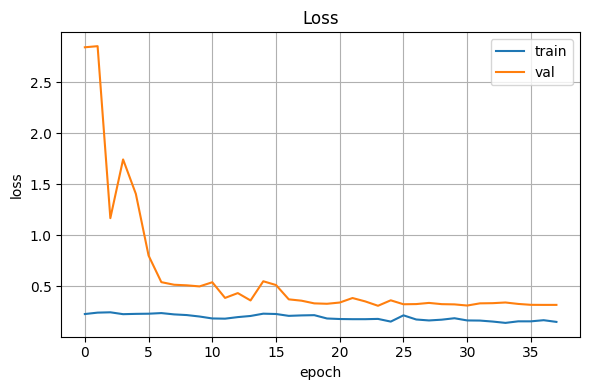

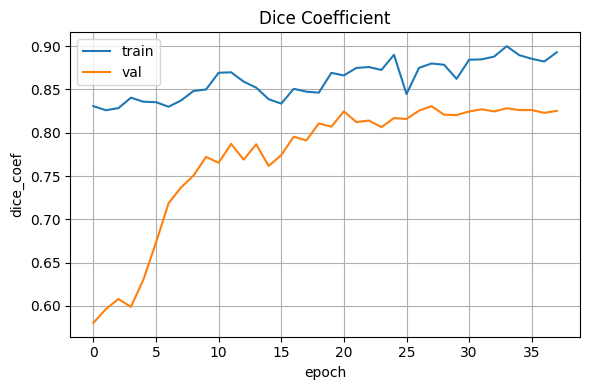

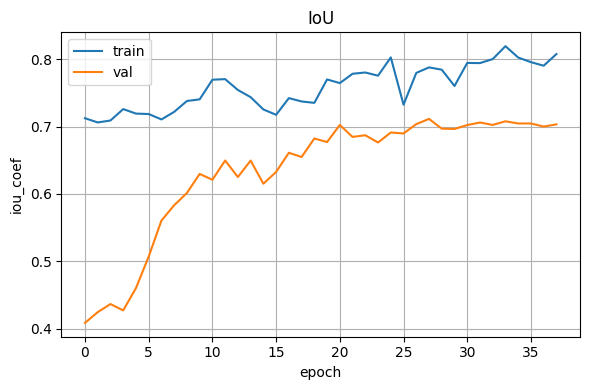

In [27]:
# =========================
# 9) Report plots (loss/dice/iou) from training history
# =========================
plots_dir = "/content/drive/MyDrive/Project3/plots"
os.makedirs(plots_dir, exist_ok=True)

def plot_series(history, key, title, fname):
    if key not in history.history:
        print(f"{key} not in history")
        return
    plt.figure(figsize=(6,4))
    plt.plot(history.history[key], label='train')
    plt.plot(history.history.get('val_' + key, []), label='val')
    plt.title(title)
    plt.xlabel('epoch')
    plt.ylabel(key)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, fname))
    plt.show()

# Use the actual history object from model.fit()
plot_series(history, 'loss', 'Loss', 'loss_best.png')
plot_series(history, 'dice_coef', 'Dice Coefficient', 'dice_best.png')
plot_series(history, 'iou_coef', 'IoU', 'iou_best.png')


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


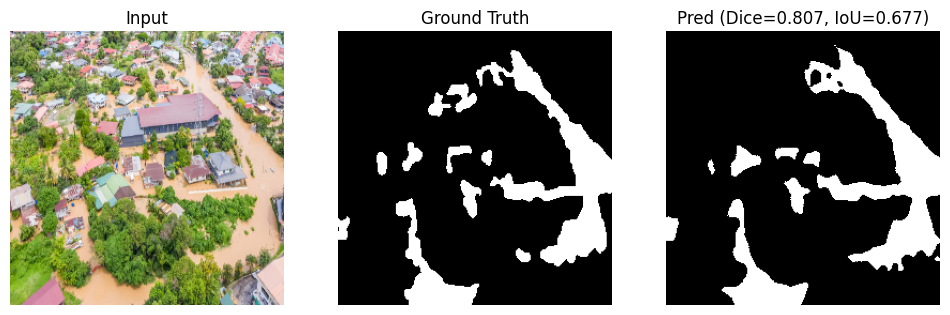

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


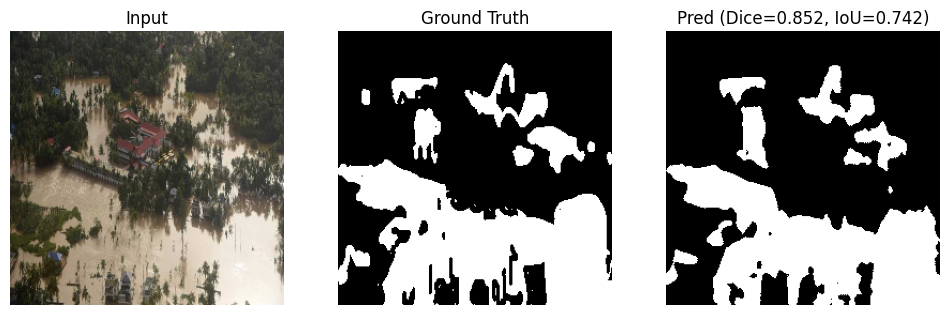

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


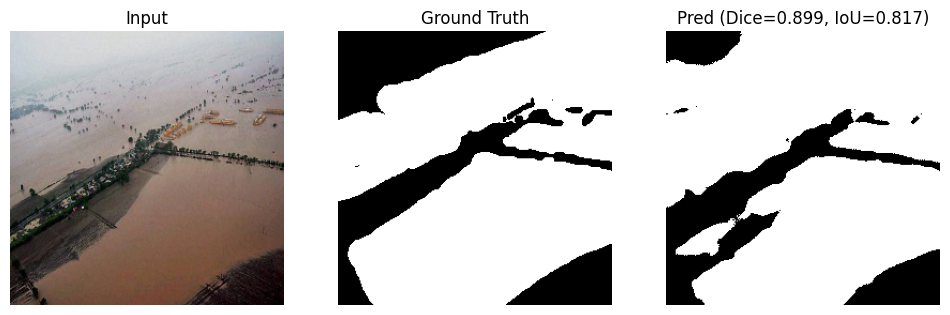

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


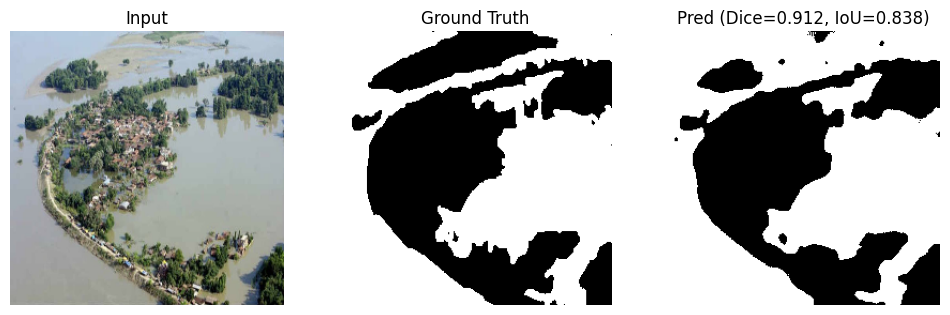

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


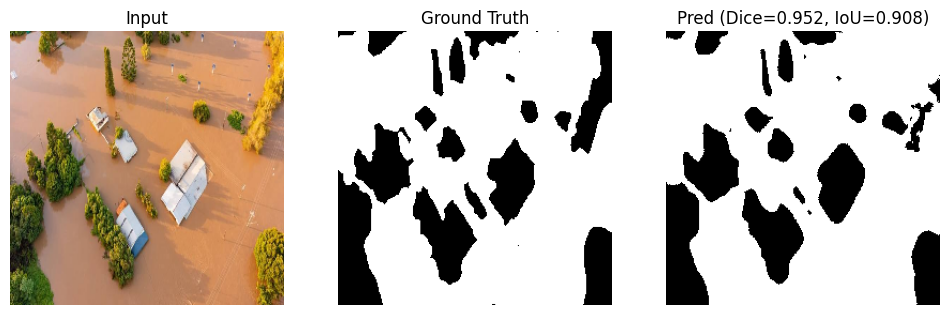

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


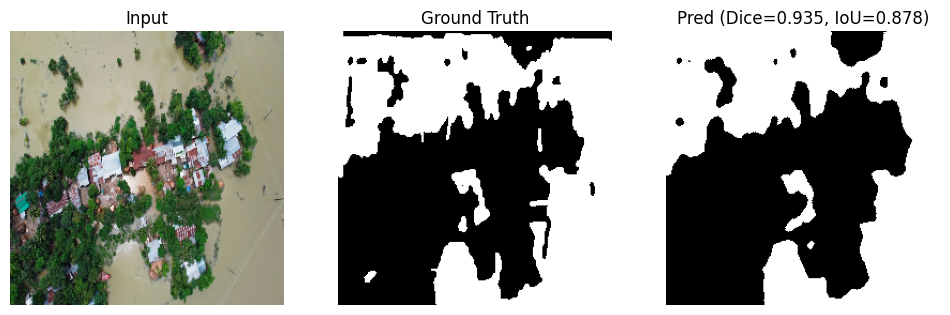

In [28]:
# =========================
# 10) Visualize predictions on TEST set (side-by-side)
# =========================
viz_dir = "/content/drive/MyDrive/Project3/predictions"
os.makedirs(viz_dir, exist_ok=True)

def visualize_and_save(model, X, Y, n=6, prefix='test'):
    idxs = np.random.choice(len(X), min(n, len(X)), replace=False)
    for i, idx in enumerate(idxs):
        pred = model.predict(X[idx:idx+1])[0]
        pred_bin = (pred > 0.5).astype(np.uint8)

        d = float(dice_coef(Y[idx], pred).numpy())
        j = float(iou_coef(Y[idx], pred).numpy())

        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1); plt.imshow(X[idx]); plt.title('Input'); plt.axis('off')
        plt.subplot(1,3,2); plt.imshow(Y[idx].squeeze(), cmap='gray'); plt.title('Ground Truth'); plt.axis('off')
        plt.subplot(1,3,3); plt.imshow(pred_bin.squeeze(), cmap='gray'); plt.title(f'Pred (Dice={d:.3f}, IoU={j:.3f})'); plt.axis('off')
        out = os.path.join(viz_dir, f"{prefix}_{i}.png")
        plt.savefig(out); plt.show()

visualize_and_save(best_model, X_test, y_test, n=6, prefix='test')

In [30]:
# =========================
# 11) Save final best model and summary CSV
# =========================
export_dir = "/content/drive/MyDrive/Project3/final_output"
os.makedirs(export_dir, exist_ok=True)
final_model_path = os.path.join(export_dir, "best_unet_final.keras")
best_model.save(final_model_path)
print("Saved final model to:", final_model_path)

# Save summary CSV
summary_csv = os.path.join(export_dir, "final_metrics_summary.csv")
with open(summary_csv, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['timestamp', 'test_metrics_names', 'test_metrics_values'])
    writer.writerow([datetime.now().isoformat(), names, test_res])
print("Saved summary to:", summary_csv)

# Print final info
print("All done — best model evaluated on test set.")
print("Plots saved to:", plots_dir)
print("Panels saved to:", viz_dir)
print("Final model saved to:", final_model_path)


Saved final model to: /content/drive/MyDrive/Project3/final_output/best_unet_final.keras
Saved summary to: /content/drive/MyDrive/Project3/final_output/final_metrics_summary.csv
All done — best model evaluated on test set.
Plots saved to: /content/drive/MyDrive/Project3/plots
Panels saved to: /content/drive/MyDrive/Project3/predictions
Final model saved to: /content/drive/MyDrive/Project3/final_output/best_unet_final.keras


In [32]:
# Get the best validation Dice from training history
if 'val_dice_coef' in history.history:
    best_val_dice = max(history.history['val_dice_coef'])
else:
    best_val_dice = None

print("All done — best validation Dice:", best_val_dice)
print("Plots saved to:", plots_dir)
print("Panels saved to:", viz_dir)
print("Final model saved to:", final_model_path)


All done — best validation Dice: 0.8307589292526245
Plots saved to: /content/drive/MyDrive/Project3/plots
Panels saved to: /content/drive/MyDrive/Project3/predictions
Final model saved to: /content/drive/MyDrive/Project3/final_output/best_unet_final.keras


In [33]:
def predict_flood_coverage(model, image, img_size=(256,256)):
    """
    model      : trained UNet model
    image      : numpy array or loaded image (H,W,3)
    img_size   : input size of the model
    Returns: predicted mask and flood coverage fraction (0-1)
    """
    import cv2
    import numpy as np

    # Preprocess
    img_resized = cv2.resize(image, img_size) / 255.0
    img_input = np.expand_dims(img_resized.astype(np.float32), 0)  # batch dimension

    # Predict mask
    pred_mask = model.predict(img_input)[0]  # remove batch dim
    pred_mask_bin = (pred_mask > 0.5).astype(np.float32)

    # Compute flood coverage
    coverage = pred_mask_bin.mean()  # fraction of pixels predicted as flood
    return pred_mask_bin, coverage


In [34]:
import matplotlib.pyplot as plt

def visualize_flood_prediction(image, pred_mask, coverage):
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(pred_mask.squeeze(), cmap='Blues')
    plt.title(f"Predicted Flood Mask\nCoverage: {coverage*100:.2f}%")
    plt.axis("off")
    plt.show()


Available images: ['1000.jpg', '0.jpg', '1.jpg', '10.jpg', '1084.jpg', '1001.jpg', '1025.jpg', '1057.jpg', '1034.jpg', '1044.jpg', '1008.jpg', '1062.jpg', '1045.jpg', '1054.jpg', '1056.jpg', '1047.jpg', '1027.jpg', '1050.jpg', '1053.jpg', '1081.jpg', '1040.jpg', '1018.jpg', '1004.jpg', '1063.jpg', '1003.jpg', '1031.jpg', '1076.jpg', '1048.jpg', '1032.jpg', '1075.jpg', '1055.jpg', '1026.jpg', '1042.jpg', '1059.jpg', '1066.jpg', '1052.jpg', '1041.jpg', '1017.jpg', '1002.jpg', '1037.jpg', '1007.jpg', '1073.jpg', '1051.jpg', '1013.jpg', '1030.jpg', '1036.jpg', '1009.jpg', '1060.jpg', '1023.jpg', '1049.jpg', '1033.jpg', '1058.jpg', '1016.jpg', '1069.jpg', '1024.jpg', '1065.jpg', '1015.jpg', '1022.jpg', '1068.jpg', '1005.jpg', '1021.jpg', '1082.jpg', '1035.jpg', '1006.jpg', '1014.jpg', '1039.jpg', '1064.jpg', '1011.jpg', '1020.jpg', '1046.jpg', '1029.jpg', '1074.jpg', '1071.jpg', '1038.jpg', '1067.jpg', '1043.jpg', '1010.jpg', '1028.jpg', '1077.jpg', '1083.jpg', '1080.jpg', '1079.jpg', '1012

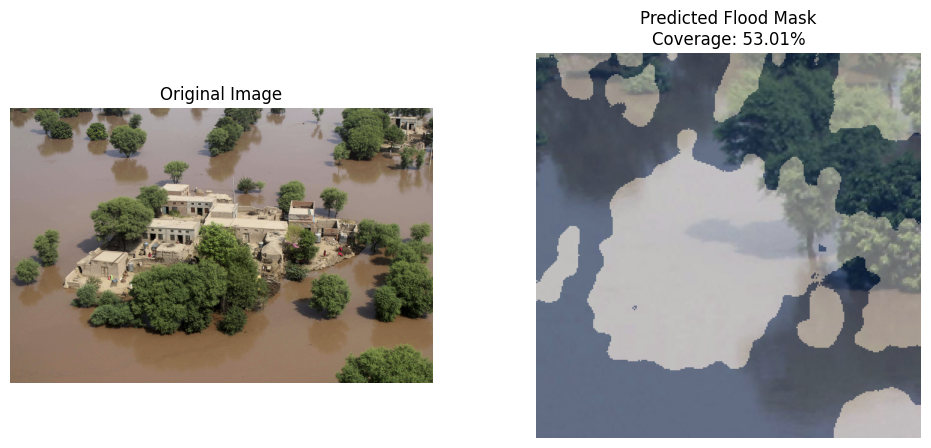

Predicted flood coverage: 53.01%


In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf

# ---------- Folder containing images ----------
image_folder = "/content/drive/MyDrive/Project3/disaster/Image/"

# List all image files
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
if not image_files:
    raise FileNotFoundError(f"No images found in folder: {image_folder}")

print("Available images:", image_files)

# Pick the first image (or change index to select another)
selected_image = image_files[0]
new_image_path = os.path.join(image_folder, selected_image)
print("Using image:", new_image_path)

# ---------- Functions ----------
def predict_flood_coverage(model, image, img_size=(256,256)):
    """Predict flood mask and calculate coverage"""
    img_resized = cv2.resize(image, img_size) / 255.0
    img_input = np.expand_dims(img_resized.astype(np.float32), 0)
    pred = model.predict(img_input)[0]
    pred_bin = (pred > 0.5).astype(np.float32)
    coverage = pred_bin.mean()
    return pred_bin, coverage

def visualize_flood_prediction(image, pred_mask, coverage):
    """Display original image and predicted mask"""
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(image)
    plt.imshow(pred_mask.squeeze(), cmap='Blues', alpha=0.4)
    plt.title(f"Predicted Flood Mask\nCoverage: {coverage*100:.2f}%")
    plt.axis("off")
    plt.show()

# ---------- Load Image ----------
img = cv2.imread(new_image_path)
if img is None:
    raise ValueError(f"Failed to load image. Check the file format: {new_image_path}")

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# ---------- Predict & Visualize ----------
pred_mask, coverage = predict_flood_coverage(best_model, img)
visualize_flood_prediction(img, pred_mask, coverage)

print(f"Predicted flood coverage: {coverage*100:.2f}%")
